# ML818 RL | CW2

Hugo Touchette

Started: 5 July 2022

Last updated: 8 July 2022

Python 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_minigrid
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import *
import pickle
from os.path import exists
import time
import hashlib
%config InlineBackend.figure_format = 'svg'

## Experiments

### Load environment

In [396]:
env = gym.make('MiniGrid-Empty-8x8-v0')

### Action space

7 actions in total, numbered 0 to 6:

- Turn left
- Turn right
- Move forward
- Pick up an object
- Drop the object being carried
- Toggle (open doors, interact with objects)
- Done

In [388]:
print('Number of actions:', env.action_space.n)

Number of actions: 7


Here we'll be using only the first 3 actions (0-2):

In [389]:
a = np.random.randint(0, env.action_space.n-4)
print("Action a: %d was generated" % a)

Action a: 2 was generated


### Observation

In [397]:
env.reset()

{'image': array([[[2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0],
         [2, 5, 0]],
 
        [[2, 5, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[2, 5, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[2, 5, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[2, 5, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 0, 0],
         [1, 

In [398]:
env = ImgObsWrapper(env)
env.reset()

array([[[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0],
        [2, 5, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[2, 5, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]]], dtype=uint8)

Extract relevant information from observation:

In [3]:
def extractObjectInformation(observation):
    (rows, cols, x) = obs.shape
    tmp = np.reshape(obs,[rows*cols*x,1], 'F')[0:rows*cols]
    return np.reshape(tmp, [rows,cols],'F')

In [400]:
obs = env.reset()
extractObjectInformation(obs)

array([[2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2],
       [2, 2, 2, 2, 2, 2, 2],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1],
       [2, 1, 1, 1, 1, 1, 1]], dtype=uint8)

In [401]:
obs.shape

(7, 7, 3)

State id:
- unseen: 0
- empty: 1
- wall: 2
- floor: 3
- door: 4
- key: 5
- ball: 6
- box: 7
- goal: 8
- lava: 9
- agent: 10

Here we use a basic grid without states 3-10, so states only 0-2 with possible state 8 as well.

### Hash function

We can use the simple (perfect) hash function described in 

- https://math.stackexchange.com/questions/188003/hash-function-for-matrices-over-finite-field-matlab

Here we have states from 0 to 2, so $p$ should be $3$. However, as we get overflow with this value, we must use $p=2$ instead, giving a non-perfect hash function.

In [8]:
def hashState(state):
    (rows, cols) = state.shape
    hash = 0
    p = 2
    for i in range(rows):
        for j in range(cols):
            hash = p*hash + state[i,j]
    return hash

In [500]:
currentS = extractObjectInformation(obs)
hashState(currentS)

1125899929861755

The largest hash value is

In [404]:
currentS = np.ones((7,7), dtype=int)*2
hashState(currentS)

1125899906842622

Simpler solution: use hashlib sha1 or sha256 directly. That's the preferred option.

In [5]:
def hashState(state):
    return hashlib.sha1(state.tobytes()).hexdigest()

In [502]:
currentS = extractObjectInformation(obs)
hashState2(currentS)

'4d6af5c5b5956d5e5157ca7c7e4e623b9cc13392'

### Reward

The reward is only given when reaching the goal as
$$
1-0.9 \frac{\textrm{no steps used to reach goal}}{256}
$$
256 being the max number of steps.

There no reward given as actions are taken before reaching the goal.

There's apparently also a 0.1 reward obtained for not reaching the goal before the pre-defined max no of steps. I could not see this in the minigrid.py file.

### Goal check

In [405]:
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)
obs = env.reset()
extractObjectInformation(obs)

# Move to target: south and east
obs, reward, done, info = env.step(1)
for i in range(5):
    obs, reward, done, info = env.step(2)

obs, reward, done, info = env.step(0)

for i in range(4):
    obs, reward, done, info = env.step(2)

currentS = extractObjectInformation(obs)
print(done)
print(currentS)
if currentS[3,5]==8:
    print('Goal seen.')

# Move to target: east and south
obs = env.reset()
for i in range(5):
    obs, reward, done, info = env.step(2)

obs, reward, done, info = env.step(1)

for i in range(4):
    obs, reward, done, info = env.step(2)

currentS = extractObjectInformation(obs)
print(done)
print(currentS)
if currentS[3,5]==8:
    print('Goal seen.')


False
[[2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]]
Goal seen.
False
[[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 8 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]
 [2 2 2 2 2 1 1]]
Goal seen.


Check when reward is obtained.

In [406]:
bs = env.reset()
for i in range(5):
    obs, reward, done, info = env.step(2)

obs, reward, done, info = env.step(1)

for i in range(5):
    obs, reward, done, info = env.step(2)

currentS = extractObjectInformation(obs)
print(done, reward)
print(currentS)

True 0.961328125
[[2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]
 [2 2 2 2 2 2 1]]


Reaching the goal in front: if currentState[3][5] == 8 and forward action is taken.

Discussing with Herman: that stopping rule is not important for training. It's only important for testing, as a reward of 0.1 is given when the agent doesn't reach the target within max_nsteps steps. In testing, we want to avoid that reward.

## Simulation

10.0 % done. Reward =  0
20.0 % done. Reward =  0.46562499999999996
30.0 % done. Reward =  0.736328125
40.0 % done. Reward =  0.876953125
50.0 % done. Reward =  0.891015625
60.0 % done. Reward =  0.7609375
70.0 % done. Reward =  0.940234375
80.0 % done. Reward =  0.869921875
90.0 % done. Reward =  0.94375


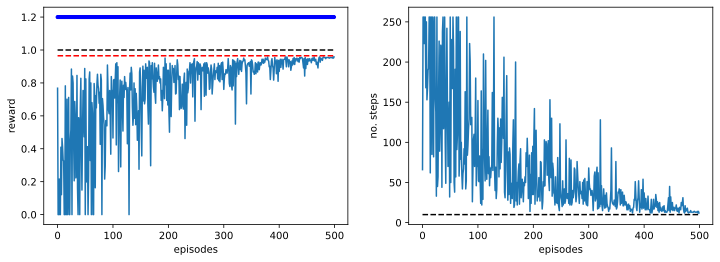

In [8]:
# Parameters
episodes = 500
max_steps = 500
epsmax = 0.9
epsmin = 0.1
deps = (epsmax - epsmin)/episodes
gamma = 0.5
alpha = 0.2
nactions = 3
Q = {}
rewardlist = np.zeros(episodes)
reachedlist = np.zeros(episodes)
stepcountlist = np.zeros(episodes)
verboseFlag = True

plt.figure(figsize=(12, 4))

# Load environment
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)

# First observation
obs = env.reset()
currentState = extractObjectInformation(obs)
currentStateKey = hashState(currentState)
Q[currentStateKey] = np.zeros(nactions)  

# Training
for e in range(episodes):
    eps = epsmax - e*deps
    obs = env.reset()
    cumreward = 0
    stepcount = 0

    for i in range(max_steps):

        # epsilon greedy action
        if np.random.random() < eps:
            a = np.random.randint(0, nactions)
        else:
            a = np.argmax(Q[currentStateKey])

        # Forward step
        obs, reward, done, info = env.step(a)
        nextState = extractObjectInformation(obs)
        nextStateKey = hashState(nextState)
        cumreward += reward

        # Initialise key if seen for the first time
        if nextStateKey not in Q:
            Q[nextStateKey] = np.zeros(nactions)
        
        # Q learning
        maxQ = np.max(Q[nextStateKey])
        Q[currentStateKey][a] = (1-alpha)*Q[currentStateKey][a] + alpha*(reward + gamma*maxQ)
        currentState = nextState
        currentStateKey = nextStateKey
        stepcount += 1

        # Stopping rule (from minigrid/run_test.py)
        if done:
            reachedlist[e] = 1.2
            break

    rewardlist[e] = cumreward
    stepcountlist[e] = stepcount
    
    if verboseFlag:
        if e > 0 and (e % (episodes/10) == 0):
            print(e/episodes*100, '% done.', 'Reward = ', cumreward)

plt.subplot(1,2,1)
plt.plot(range(episodes), rewardlist)
plt.plot(range(episodes), np.ones(episodes), 'k--')
plt.plot(range(episodes), np.ones(episodes)-0.9*10/256, 'r--')
plt.plot(range(episodes), reachedlist, 'b.')
plt.xlabel('episodes')
plt.ylabel('reward')

plt.subplot(1,2,2)
plt.plot(range(episodes), stepcountlist)
plt.plot(range(episodes), np.ones(episodes)*10, 'k--')
plt.xlabel('episodes')
plt.ylabel('no. steps')
plt.show()

## Hyperparameter tuning

In [461]:
nrepetitions = 10
episodes = 100
max_steps = 500
nactions = 3
epsmax = 0.5
epsmin = 0.1
deps = (epsmax - epsmin)/episodes

gammaa = 0.1
gammab = 0.3
ngamma = 5
gammarange = np.linspace(gammaa, gammab, ngamma)
dgamma = (gammab - gammaa)/ngamma

alphaa = 0.6
alphab = 0.8
nalpha = 5
alpharange = np.linspace(alphaa, alphab, nalpha)
dalpha = (alphab - alphaa)/nalpha

fullresults = np.zeros((ngamma, nalpha))

# Load environment
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)

currentmax = -5.0
posmax = [0, 0]

for igamma, gamma in enumerate(gammarange):
    for jalpha, alpha in enumerate(alpharange):
        meanrew = 0.0
        for n in range(nrepetitions):
            Q = {}
    
            # First observation
            obs = env.reset()
            currentState = extractObjectInformation(obs)
            currentStateKey = hashState(currentState)
            Q[currentStateKey] = np.zeros(nactions)  

            # Training
            for e in range(episodes):
                eps = epsmax - e*deps
                obs = env.reset()
                cumreward = 0

                for i in range(max_steps):

                    # epsilon greedy action
                    if np.random.random() < eps:
                        a = np.random.randint(0, nactions)
                    else:
                        a = np.argmax(Q[currentStateKey])

                    # Forward step
                    obs, reward, done, info = env.step(a)
                    nextState = extractObjectInformation(obs)
                    nextStateKey = hashState(nextState)
                    cumreward += reward

                    # Initialise key if seen for the first time
                    if nextStateKey not in Q:
                        Q[nextStateKey] = np.zeros(nactions)
        
                    # Q learning
                    maxQ = np.max(Q[nextStateKey])
                    Q[currentStateKey][a] = (1-alpha)*Q[currentStateKey][a] + alpha*(reward + gamma*maxQ)
                    currentState = nextState
                    currentStateKey = nextStateKey

                    # Stopping rule
                    if done:
                        break

            meanrew += cumreward
                
        meanrew /= nrepetitions
        fullresults[igamma,jalpha] = meanrew
        if meanrew > currentmax:
            currentmax = meanrew
            posmax[0] = igamma
            posmax[1] = jalpha

print('Max =', currentmax)
print('Theoretical max =', 1-0.9*10/256)
print('epsmin =', epsmin)
print('epsmax =', epsmax)
print('Optimal gamma =', gammaa+posmax[0]*dgamma)
print('Optimal alpha =', alphaa+posmax[1]*dalpha)

Max = 0.8688671875
Theoretical max = 0.96484375
epsmin = 0.1
epsmax = 0.5
Optimal gamma = 0.26
Optimal alpha = 0.76


In [460]:
fullresults

array([[0.73246094, 0.56582031, 0.69097656, 0.77078125, 0.77605469],
       [0.61539062, 0.66179687, 0.80488281, 0.79398438, 0.8340625 ],
       [0.75601562, 0.78203125, 0.75003906, 0.70046875, 0.75144531],
       [0.70785156, 0.69625   , 0.7778125 , 0.78203125, 0.6709375 ],
       [0.65476562, 0.70855469, 0.75847656, 0.74757812, 0.78414063]])

## Trained agent

In [9]:
import base64
import glob
import io
from IPython.display import HTML 
from IPython import display

In [10]:
def show_video(folder):
    mp4list = glob.glob(folder+'/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [11]:
eps = 0.1
folder = 'minigridrecording'
env = gym.make('MiniGrid-Empty-8x8-v0')
env = ImgObsWrapper(env)
env = gym.wrappers.Monitor(env, folder, force=True)
obs = env.reset()

while True:
    state = extractObjectInformation(obs)
    stateKey = hashState(state)

    if np.random.random() < eps:
        a = np.random.randint(0, nactions)
    else:
        a = np.argmax(Q[stateKey])

    obs, rew, done, info = env.step(a)
    if done:
        break
        
env.close()
show_video(folder)